This notebook aims at .......

In [131]:
import pandas as pd
import numpy as np
import optuna
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, log_loss
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

root_path = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(root_path)

from src.config import load_config
from src.feature_engineering import create_diff_features, find_highly_correlated_cols, remove_low_variance_features, select_top_features

# config.yaml importation
config_file = 'config.yaml'
config_path = os.path.join(root_path, config_file)
config = load_config(config_path)

# Preprocessed data importation

In [124]:
preprocessed_data_path = os.path.join(root_path, config['preprocessed_dir'])
df_train_path = os.path.join(preprocessed_data_path, f"{config['preprocessed_train_df_name']}.csv")
df_test_path = os.path.join(preprocessed_data_path, f"{config['preprocessed_test_df_name']}.csv")

df_train = pd.read_csv(df_train_path)
df_test = pd.read_csv(df_test_path)
df_train.head()

,date,season,home,away,nb_goals_home,nb_goals_away,final_result,odd_home,odd_away,odd_draw,...,strict_rel_recent_nb_goals_conceded_by_match_home_team,strict_rel_recent_nb_goals_conceded_by_match_away_team,strict_rel_recent_goal_difference_home_team,strict_rel_recent_goal_difference_away_team,strict_rel_recent_percentage_victory_home_team,strict_rel_recent_percentage_victory_away_team,hist_nb_seasons_l1_home_team,hist_nb_seasons_l1_away_team,promoted_home_team,promoted_away_team
0,2010-08-07,2010/2011,Auxerre,Lorient,2.0,2.0,draw,1.971247,4.312213,3.288536,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,3,11,0,0
1,2010-08-07,2010/2011,Lens,Nancy,1.0,2.0,away,2.134104,3.790785,3.185679,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,6,4,0,0
2,2010-08-07,2010/2011,Lyon,Monaco,0.0,0.0,draw,1.591247,7.333642,3.985679,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,14,12,0,0
3,2010-08-07,2010/2011,Marseille,Caen,1.0,2.0,away,1.436961,9.797928,5.349965,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,14,7,0,0
4,2010-08-07,2010/2011,Nice,Valenciennes,0.0,0.0,draw,2.148390,3.712213,3.214250,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,14,4,0,0


In [125]:
primary_target = config['final_result_column']
secondary_target_home = config['nb_goals_home_column']
secondary_target_away = config['nb_goals_away_column']

X_train = df_train.drop(columns=[primary_target, secondary_target_home, secondary_target_away, config['date_column'], config['season_column']])
X_test = df_test.drop(columns=[primary_target, secondary_target_home, secondary_target_away, config['date_column'], config['season_column']])

y_train_primary = df_train[primary_target]
y_test_primary = df_test[primary_target]

In [126]:
X_train.columns

Index(['home', 'away', 'odd_home', 'odd_away', 'odd_draw',
       'current_season_points_home_team', 'current_season_points_away_team',
       'current_season_general_ranking_home_team',
       'current_season_general_ranking_away_team',
       'current_season_nb_goals_scored_home_team',
       'current_season_nb_goals_scored_away_team',
       'current_season_nb_goals_conceded_home_team',
       'current_season_nb_goals_conceded_away_team',
       'current_season_goal_difference_home_team',
       'current_season_goal_difference_away_team',
       'current_season_attack_ranking_home_team',
       'current_season_attack_ranking_away_team',
       'current_season_defense_ranking_home_team',
       'current_season_defense_ranking_away_team',
       'current_season_nb_points_home_team_at_home',
       'current_season_nb_points_away_team_away',
       'current_season_home_team_ranking_at_home',
       'current_season_away_team_ranking_away',
       'current_season_nb_goals_scored_home_team

# Feature engineering

Since we want to model the final issue of a match, exhaustive data related to home and away teams is not necessary. That is why for each pair of similar columns for home and away teams, we create the difference between these two columns.

In [127]:
patterns = [
        ("_home_team_ranking_at_home", "_away_team_ranking_away"),
        ("_home_team_at_home", "_away_team_away"),
        ("_home_team", "_away_team"),
        ("_at_home", "_away"),
        ("_home", "_away")
]

X_train_primary = create_diff_features(X_train, patterns=patterns)
X_test_primary = create_diff_features(X_test, patterns=patterns)

X_train_primary.head()

,home,away,odd_home,odd_away,odd_draw,diff_current_season,diff_current_season_nb_points,diff_current_season_nb_goals_scored,diff_current_season_nb_goals_conceded,diff_current_season_points,...,diff_rel_recent_nb_goals_conceded_by_match,diff_rel_recent_goal_difference,diff_rel_recent_percentage_victory,diff_strict_rel_recent_nb_points_by_match,diff_strict_rel_recent_nb_goals_scored_by_match,diff_strict_rel_recent_nb_goals_conceded_by_match,diff_strict_rel_recent_goal_difference,diff_strict_rel_recent_percentage_victory,diff_hist_nb_seasons_l1,diff_promoted
0,Auxerre,Lorient,1.971247,4.312213,3.288536,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-8,0
1,Lens,Nancy,2.134104,3.790785,3.185679,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,0
2,Lyon,Monaco,1.591247,7.333642,3.985679,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,0
3,Marseille,Caen,1.436961,9.797928,5.349965,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7,0
4,Nice,Valenciennes,2.148390,3.712213,3.214250,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10,0


# Feature Selection

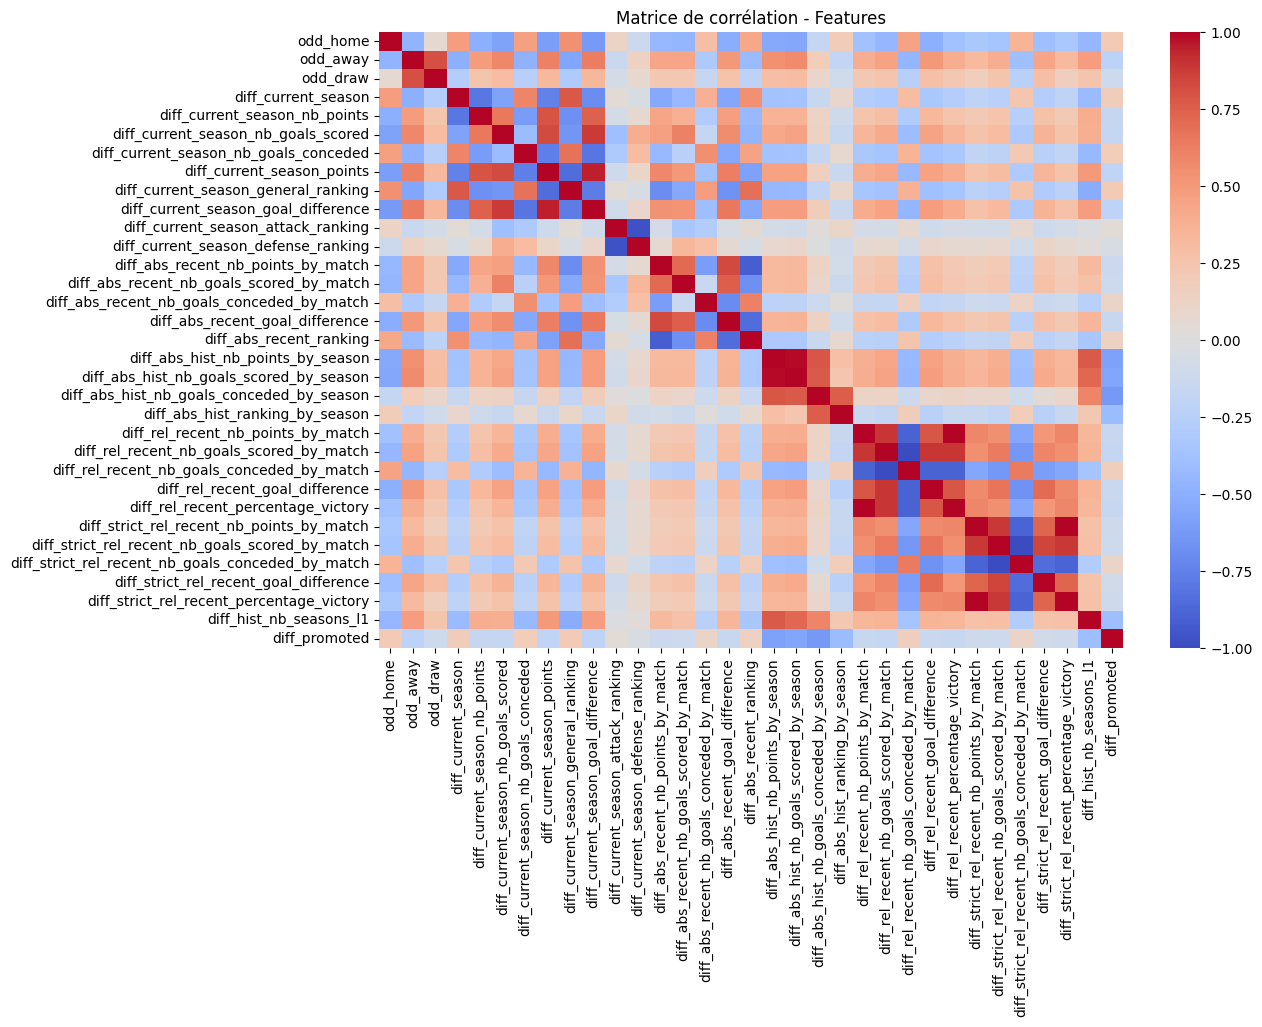

In [129]:
corr = X_train_primary.corr(numeric_only=True)
plt.figure(figsize=(12,8))
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Matrice de corrélation - Features")
plt.show()

In [132]:
from sklearn.feature_selection import VarianceThreshold

def remove_low_variance_features(df: pd.DataFrame, threshold: float = 0.01) -> pd.DataFrame:
    """
    Supprime les colonnes avec très faible variance.
    """
    numeric_df = df.select_dtypes(include=["number"])
    selector = VarianceThreshold(threshold)
    selector.fit(numeric_df)

    kept = numeric_df.columns[selector.get_support()]
    dropped = list(set(numeric_df.columns) - set(kept))

    if len(dropped) > 0:
        print(f"🧽 {len(dropped)} colonnes supprimées pour faible variance: {dropped}")
    else:
        print("✅ Aucune colonne supprimée (variance OK).")

    return df[kept]


In [134]:
test = VarianceThreshold(0.05)
test.fit(X_train_primary.select_dtypes(include=["number"]))

,threshold,0.05


In [133]:
remove_low_variance_features(X_train_primary)

✅ Aucune colonne supprimée (variance OK).


,odd_home,odd_away,odd_draw,diff_current_season,diff_current_season_nb_points,diff_current_season_nb_goals_scored,diff_current_season_nb_goals_conceded,diff_current_season_points,diff_current_season_general_ranking,diff_current_season_goal_difference,...,diff_rel_recent_nb_goals_conceded_by_match,diff_rel_recent_goal_difference,diff_rel_recent_percentage_victory,diff_strict_rel_recent_nb_points_by_match,diff_strict_rel_recent_nb_goals_scored_by_match,diff_strict_rel_recent_nb_goals_conceded_by_match,diff_strict_rel_recent_goal_difference,diff_strict_rel_recent_percentage_victory,diff_hist_nb_seasons_l1,diff_promoted
0,1.971247,4.312213,3.288536,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-8,0
1,2.134104,3.790785,3.185679,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,0
2,1.591247,7.333642,3.985679,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,0
3,1.436961,9.797928,5.349965,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7,0
4,2.148390,3.712213,3.214250,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5140,1.683647,6.162868,4.528512,-3,7,10,6,11,-6,4,...,-0.2,2.0,0.0,1.2,1.2,-1.2,12.0,40.0,7,0
5141,1.663647,6.144297,4.715655,-4,9,34,-9,31,-12,43,...,-0.6,6.0,20.0,2.4,1.2,-1.2,12.0,80.0,1,0
5142,4.299362,2.287154,4.091369,16,-28,-44,23,-44,15,-67,...,2.2,-22.0,-100.0,-3.0,-2.0,2.0,-20.0,-100.0,-7,1
5143,2.667933,2.905726,3.452797,0,3,-12,2,-2,1,-14,...,0.4,-4.0,-20.0,1.2,0.8,-0.8,8.0,40.0,-4,0


# Feature Selection

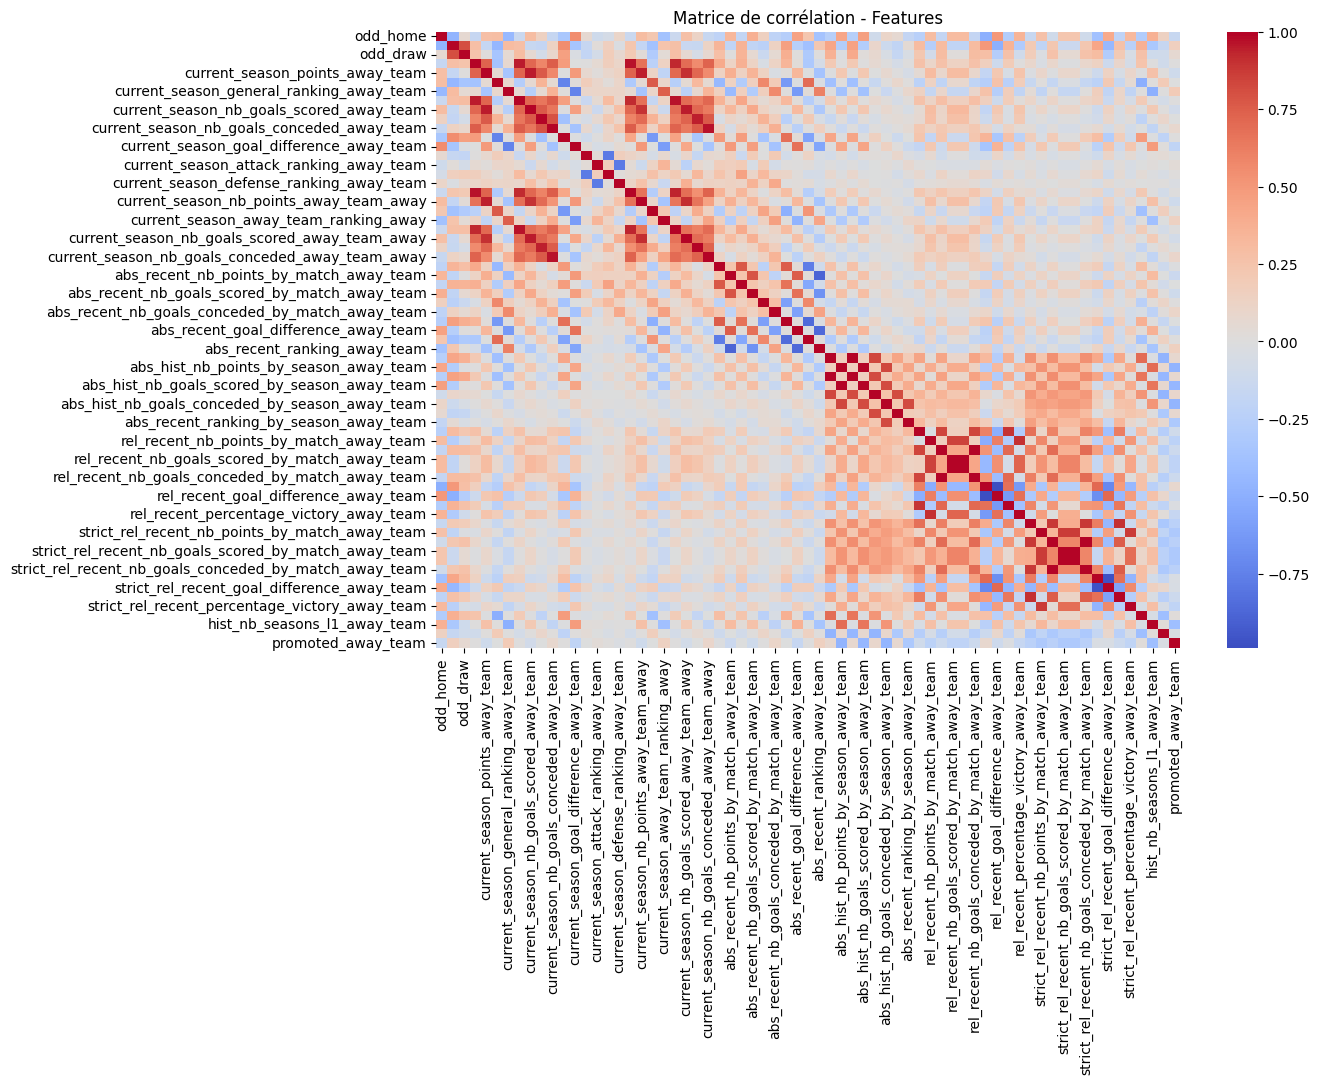

In [23]:
corr = X_train.corr(numeric_only=True)
plt.figure(figsize=(12,8))
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Matrice de corrélation - Features")
plt.show()


In [24]:
import numpy as np
import pandas as pd

def find_highly_correlated_cols(df, cols=None, threshold=0.95):
    """
    Retourne la liste de colonnes à supprimer pour éliminer les corrélations > threshold.
    Logique : pour chaque paire fortement corrélée, on supprime la colonne qui a la plus
    grande corrélation moyenne absolue avec les autres (plus 'redondante').
    - df: DataFrame complet
    - cols: liste facultative de colonnes numériques à considérer (par défaut toutes les numériques)
    - threshold: seuil absolu de corrélation au-dessus duquel on considère la redondance
    """
    if cols is None:
        numeric = df.select_dtypes(include=[np.number]).columns.tolist()
    else:
        numeric = cols

    if len(numeric) <= 1:
        return []

    corr = df[numeric].corr().abs()

    # Ne garder que la triangulaire supérieure (exclut la diagonale)
    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))

    # Trouver paires avec corr > threshold
    to_drop = set()
    # calcule la corr moyenne absolue (hors diagonale) pour guider quelcol dropper
    mean_abs_corr = corr.mean().sort_values(ascending=False)

    # itère sur les paires
    for col in upper.columns:
        high_corr_with = upper.index[upper[col] > threshold].tolist()
        for other in high_corr_with:
            if other in to_drop or col in to_drop:
                # si déjà marqué à dropper, skip
                continue
            # choisir la colonne à dropper : celle avec mean_abs_corr plus élevée
            if mean_abs_corr.loc[col] >= mean_abs_corr.loc[other]:
                to_drop.add(col)
            else:
                to_drop.add(other)

    return list(to_drop)


In [25]:
# X_train est ton DataFrame d'entraînement
cols_to_consider = X_train.select_dtypes(include=[np.number]).columns.tolist()
to_drop = find_highly_correlated_cols(X_train, cols=cols_to_consider, threshold=0.95)
print("Colonnes à dropper :", to_drop)

X_train_reduced = X_train.drop(columns=to_drop, errors="ignore")
X_test_reduced = X_test.drop(columns=to_drop, errors="ignore")


Colonnes à dropper : ['current_season_nb_goals_conceded_away_team', 'strict_rel_recent_goal_difference_home_team', 'abs_hist_nb_goals_scored_by_season_home_team', 'strict_rel_recent_nb_goals_conceded_by_match_away_team', 'rel_recent_goal_difference_home_team', 'strict_rel_recent_nb_goals_conceded_by_match_home_team', 'current_season_nb_goals_scored_away_team', 'rel_recent_nb_goals_conceded_by_match_away_team', 'rel_recent_nb_goals_conceded_by_match_home_team', 'current_season_points_home_team', 'current_season_nb_goals_scored_home_team', 'abs_hist_nb_goals_scored_by_season_away_team']


# Fitting

## Model xxxx

## Evaluation

# Final model storage